In [1]:
import pandas as pd
import sys
[sys.path.append(i) for i in ['.', '..']]
from config import DATA_DIR,FINAL_ANNOTATION_FILE_PATH
from os.path import join
from ast import literal_eval 

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

In [2]:
df_m = pd.read_csv(join(DATA_DIR, "counterspeech_diversity_evaluation_by_model.csv"))

In [3]:
df_m

,model,corpus_distinct_1grams,corpus_distinct_2grams,corpus_self_bleu_mean,corpus_self_bleu_std,corpus_jaccard_diversity_mean,corpus_jaccard_diversity_std,corpus_distinct_3_sentence_starts,common_sentence_starts_3,common_sentences,corpus_semantic_similarity_mean,corpus_semantic_similarity_std,mean_sentence_length,pct_questions,pct_exclamations,mean_text_length,response_distinct_2grams_mean,response_distinct_2grams_std,messages_with_emojis,unique_emojis,responses_with_hashtags,hashtags,responses_with_urls,unique_urls,messages_with_entities,persons_message,persons_response,organizations_message,organizations_response,sentiment
0,llama3,0.150566,0.475825,0.470451,0.100121,0.774002,0.037507,0.296296,"[(""It's also important"", 59), (""Let's focus on...","[(""Let's focus on the facts"", 4), (""Instead of...",0.641531,0.119619,22.093192,0.000868,0.000090,1267.414474,0.949263,0.035295,0,set(),8,"['#Qanon', '#Qanon', '#NHI', '#UFO', '#TruthOv...",0,set(),109,"[['Biden'], [], [], ['Benjamin Netanyahu'], ['...","[['Joe Biden'], [], [], ['Benjamin Netanyahu']...","[[], [], ['#', 'Qanon'], ['QAnon'], [], ['MAGA...","[[], [], ['#', 'Qanon', '#', 'Qanon'], ['QAnon...","Counter({'positive': 108, 'negative': 43, 'neu..."
1,mistral,0.257401,0.724732,0.201746,0.075483,0.845654,0.021410,0.658790,"[(""Let's focus on"", 27), (""It's important to"",...","[('2', 5), ('', 4), ('4', 3), ('3', 3), ('Vacc...",0.581122,0.123281,18.925994,0.001075,0.000244,795.046053,0.992059,0.012807,5,"{'🧐', '💪', '💬', '🍵', '💡', '🔍', '💉', '🇱', '📰', ...",41,"['#PromoteUnderstanding', '#EngageInCriticalTh...",2,"{'https://www.fda.gov/', 'https://www.epa.gov/...",94,"[['Biden'], [], [], ['Benjamin Netanyahu'], ['...","[['Biden'], [], [], ['Benjamin Netanyahu'], []...","[[], [], ['#', 'Qanon'], ['QAnon'], [], ['MAGA...","[[], [], ['QAnon', 'FBI', 'The International L...","Counter({'positive': 108, 'negative': 41, 'neu..."
2,gpt4o,0.222070,0.692424,0.225919,0.076121,0.827805,0.022569,0.594008,"[(""It's understandable to"", 40), (""It's import...","[(""It's important to examine claims critically...",0.648989,0.116230,18.048504,0.002058,0.000400,709.375000,0.994808,0.008320,0,set(),3,"['#KenyaFacts', '#ConsiderBothSides', '#Scienc...",0,set(),51,"[['Biden'], [], [], ['Benjamin Netanyahu'], ['...","[['Biden'], [], [], [], [], [], [], [], ['Geor...","[[], [], ['#', 'Qanon'], ['QAnon'], [], ['MAGA...","[[], [], [], [], [], [], [], ['the World Econo...","Counter({'positive': 142, 'negative': 9, 'neut..."
3,random,0.200843,0.610766,0.290158,0.122831,0.821016,0.036459,0.486066,"[(""It's important to"", 42), (""Let's focus on"",...","[(""However it's essential to separate facts fr...",0.600000,0.117009,20.432543,0.001561,0.000360,964.059211,0.974534,0.036762,0,set(),11,"['#SecondAmendment', '#GunSense', '#SafetyFirs...",1,"{'https://www.fda.gov/', 'https://www.epa.gov/...",86,"[['Qanon'], [], [], [], ['RFK Jr', 'Jesus'], [...","[[], [], [], [], [], ['Robert Fico'], ['Trump'...","[[], ['#', 'Qanon'], [], ['MAGA', 'QAnon'], []...",[['the Centers for Disease Control and Prevent...,"Counter({'positive': 110, 'negative': 42})"


In [4]:
# reconstruct lists form strings
for col in [c for c in df_m.columns if c.startswith("persons") or c.startswith("organizations")]:
    df_m[col] = df_m[col].map(literal_eval)


# NERs

In [5]:
persons = set()
organizations = set()
for i, row in df_m.iterrows():
    for item in [row["persons_message"],row["persons_response"]]:
        for ner in item:
            if len(ner)>0:
                persons.update(ner)

    for item in [row["organizations_message"], row["organizations_response"]]:
        for ner in item:
            if len(ner)>0:
                organizations.update(ner)
    

## Normalize persons

Before comparing persons in messages and responses, normalization is required

In [6]:
persons_normalize = {
    '@BravinYuri': None,
    '@Cafreeland': None,
    '@JustinTrudeau': "Justin Trudeau",
    '@LeilaniDowding': "Leilani Dowding",
    '@PeterMcilvenna': None,
    '@ellymelly': None,
    '@maddow': "Rachel Maddow",
    '@realDonaldTrump': "Donald Trump",
    'Alan Moore': "Alan Moore",
    'Alex Jones': "Alex Jones",
    "Alex Jones'": "Alex Jones",
    'Andersen': "Kristian Andersen",
    'BRUNSON': "Brunson",
    'Bailey': "Mark Bailey",
    'Benjamin Netanyahu': "Benjamin Netanyahu",
    'Biden': "Joe Biden",
    'Bill Gates': "Bill Gates",
    "Bill Gates'": "Bill Gates",
    'Brahmin': "Brahmin",
    'Brunson': "Brunson",
    'C. K. Hoskisson': "C. K. Hoskisson",
    'C.S. Lewis': "C. S. Lewis",
    'Clintons': "Clinton Family",
    'Corbyn': "Jeremy Corbyn",
    'D. A. Westphal': "D. A. Westphal",
    'D. E. Gereffi': "D. E. Gereffi",
    'D. J. Dicken': "D. J. Dicken",
    'Dan Hill': "Dan Hill",
    'Deb': 'Deb',
    'Derek Chauvin': "Derek Chauvin",
    'Dicken': "D. J. Dicken",
    'Donald J. Trump': "Donald Trump",
    'Donald Trump': "Donald Trump",
    "Donald Trump's": "Donald Trump",
    'E. Ash': "E. Ash",
    'Elon': "Elon Musk",
    'Elon Musk': "Elon Musk",
    'Fauci': "Anthony Fauci",
    'Fico': "Robert Fico",
    'Floyd': "George Floyd",
    'Flynn': "Michael Flynn",
    'Gates': "Bill Gates",
    'George Floyd': "George Floyd",
    "George Floyd's": "George Floyd",
    'George Floyd’s': "George Floyd",
    'George Soros': "George Soros",
    'God': None,
    'Guy Fawkes': "Guy Fawkes",
    'Harris': "Kamala Harris",
    'Hashem': 'Hashem',
    "Hillary Clinton's": "Hillary Clinton",
    'Hitler': "Adolf Hitler",
    'Igor Kirillov': "Igor Kirillov",
    "Igor Kirillov's": "Igor Kirillov",
    'Ilya Sandra Perlingieri': "Ilya Sandra Perlingieri",
    'J.R.R. Tolkien': "J. R. R. Tolkien",
    'J6ers': None,
    'JFK': "John F. Kennedy",
    'Jenrick': "Robert Jenrick",
    'Jeremy Corbyn': "Jeremy Corbyn",
    'Jesus': "Jesus Christ",
    'Jesus Christ': "Jesus Christ",
    'Jn': None,
    'Joe': "Joe Biden",
    'Joe Biden': "Joe Biden",
    'K. D. Brusca': "K. D. Brusca",
    'Kamala': "Kamala Harris",
    'Kamala Harris': "Kamala Harris",
    'Katz': 'Katz',
    'Keir Starmer': "Keir Starmer",
    'Kemi Badenoch': "Kemi Badenoch",
    "Kemi Badenoch's": "Kemi Badenoch",
    'Kennedy': "John F. Kennedy",
    'Kennedy Jr.': "Robert F. Kennedy Jr.",
    'Kerry': 'Kerry',
    'Klaus Schwab': "Klaus Schwab",
    'Kristian Andersen': "Kristian Andersen",
    'Leilani Dowding': "Leilani Dowding",
    "Leilani Dowding's": "Leilani Dowding",
    'Lewis': "C. S. Lewis",
    'Lyndon B. Johnson': "Lyndon B. Johnson",
    'M. L. Breslin': "M. L. Breslin",
    'MG': None,
    'MOUTHPIECE': None,
    'Macron': "Emmanuel Macron",
    'Maddow': "Rachel Maddow",
    'Maria Theresa': "Maria Theresa",
    'Marjorie Taylor Greene': "Marjorie Taylor Greene",
    "Marjorie Taylor Greene's": "Marjorie Taylor Greene",
    'Mark Bailey': "Mark Bailey",
    'Martin Armstrong': "Martin Armstrong",
    "Martin Armstrong's": "Martin Armstrong",
    'Mazaltov': 'Mazaltov',
    'Meg Whitman': "Meg Whitman",
    "Meg Whitman's": "Meg Whitman",
    'Michael Flynn': "Michael Flynn",
    'Mike Johnson': "Mike Johnson",
    'Milton': 'Milton',
    'Musk': "Elon Musk",
    'Norvus Ordo Seclorum': None,
    'Obama': "Barack Obama",
    'Obamas': "Barack Obama Family",
    'P. J.': 'P. J.',
    'Patsy Mink': "Patsy Mink",
    'Paul Allen': "Paul Allen",
    'Perlingieri': "Ilya Sandra Perlingieri",
    'Qanon': 'Qanon',
    'RACHEL': "Rachel Maddow",
    'RACHEL MADDOW': "Rachel Maddow",
    'RFK Jr': "Robert F. Kennedy Jr.",
    "RFK Jr's": "Robert F. Kennedy Jr.",
    'RFK Jr.': "Robert F. Kennedy Jr.",
    "RFK Jr.'s": "Robert F. Kennedy Jr.",
    'Rachel Maddow': "Rachel Maddow",
    "Rachel Maddow's": "Rachel Maddow",
    'RecallMegWhitman': "Meg Whitman",
    'Robert F. Kennedy Jr.': "Robert F. Kennedy Jr.",
    "Robert F. Kennedy Jr.'s": "Robert F. Kennedy Jr.",
    'Robert Fico': "Robert Fico",
    "Robert Fico's": "Robert Fico",
    'Robert Jenrick': "Robert Jenrick",
    'Robert Kennedy Jnr': "Robert F. Kennedy Jr.",
    'Robert Kennedy Jr.': "Robert F. Kennedy Jr.",
    "Robert Kennedy Jr.'s": "Robert F. Kennedy Jr.",
    'RobertKennedyJr': "Robert F. Kennedy Jr.",
    'Ron Paul': "Ron Paul",
    'Rothschild': "Rothschild",
    'Rush': 'Rush',
    'SHIVA': "Shiva",
    'Satan': None,
    'Scholz': "Olaf Scholz",
    'Schumer': "Chuck Schumer",
    'Schwabb': "Klaus Schwab",
    'Shiva': "Shiva",
    'Soros': "George Soros",
    'Starmer': "Keir Starmer",
    'TRUMP': "Donald Trump",
    'Tolkien': "J. R. R. Tolkien",
    'Trump': "Donald Trump",
    'Tulsi': "Tulsi Gabbard",
    'Tulsi Gabbard': "Tulsi Gabbard",
    'VIVEK': "Vivek Ramaswamy",
    'Vivek': "Vivek Ramaswamy",
    'Volodymyr Zelenskyy': "Volodymyr Zelenskyy",
    'W. T. Newburry': "W. T. Newburry",
    'W. Zhou': "W. Zhou",
    'Zakayo': "Zakayo",
    'Zelenskyy': "Volodymyr Zelenskyy",
    'ndio afanywe': None,
    'trump': "Donald Trump"
}


In [7]:
def normalize_nested_lists(nested_list, replacement_dict):
    replaced = []
    for item in nested_list: # e.g., ['Biden'] or [] or ['Robert Fico', 'Fico']
        replaced_item = [replacement_dict.get(elem, elem) for elem in item if elem]
        replaced_item = list(set(replaced_item)) # remove duplicate entries per message/response
        replaced.append(replaced_item)
    return replaced

In [8]:
df_m["persons_message_normalized"] = df_m['persons_message'].map(
    lambda x: normalize_nested_lists(x, persons_normalize))


In [9]:
df_m.loc[0, "persons_message_normalized"]

[['Joe Biden'],
 [],
 [],
 ['Benjamin Netanyahu'],
 ['Qanon'],
 [],
 ['Robert Fico'],
 [],
 ['George Floyd'],
 [],
 ['Donald Trump'],
 ['Donald Trump'],
 [],
 [],
 ['Joe Biden'],
 ['Chuck Schumer'],
 [],
 ['Adolf Hitler'],
 ['Donald Trump'],
 [],
 ['Martin Armstrong'],
 ['Donald Trump'],
 [],
 ['Donald Trump'],
 ['Donald Trump', 'Joe Biden', 'Kamala Harris', 'Rush'],
 ['Jeremy Corbyn'],
 ['Klaus Schwab', 'George Soros', 'Bill Gates'],
 [],
 ['Joe Biden',
  'Robert F. Kennedy Jr.',
  'Donald Trump',
  'Elon Musk',
  'Tulsi Gabbard'],
 [],
 ['Donald Trump', 'Hashem', 'Mazaltov'],
 ['Donald Trump'],
 ['Donald Trump', 'George Soros'],
 [None],
 [None],
 [],
 ['Barack Obama Family',
  'Bill Gates',
  'Anthony Fauci',
  'Kerry',
  'Clinton Family',
  'Klaus Schwab',
  'George Soros'],
 ['Donald Trump', 'Elon Musk'],
 [],
 ['Donald Trump'],
 ['Donald Trump'],
 [None],
 ['Emmanuel Macron', 'Keir Starmer', 'Donald Trump', 'Olaf Scholz'],
 [],
 ['Donald Trump', 'Barack Obama'],
 ['Mike Johnson',

In [10]:
df_m["persons_response_normalized"] = df_m['persons_response'].map(
    lambda x: normalize_nested_lists(x, persons_normalize))


## Normalize organizations

In [11]:
# for organizations remove "the" first before nromalizing

def remove_article_from_organizations(org_ners):
    replaced = []
    for item in org_ners: # e.g., ['the Federal Reserve'] or [] 
        replaced_item = [elem.lstrip('the') for elem in item if elem]
        replaced_item = [elem.lstrip('The ') for elem in replaced_item if elem]
        replaced.append(replaced_item)
    return replaced

In [12]:
df_m['organizations_response']

0    [[], [], [#, Qanon, #, Qanon], [QAnon], [the C...
1    [[], [], [QAnon, FBI, The International Labour...
2    [[], [], [], [], [], [], [], [the World Econom...
3    [[the Centers for Disease Control and Preventi...
Name: organizations_response, dtype: object

In [13]:
df_m['organizations_response'].map(remove_article_from_organizations)

0    [[], [], [#, Qanon, #, Qanon], [QAnon], [Cente...
1    [[], [], [QAnon, FBI, International Labour Org...
2    [[], [], [], [], [], [], [], [World Economic F...
3    [[Centers for Disease Control and Prevention, ...
Name: organizations_response, dtype: object

In [14]:
df_m["organizations_response_normalized"] = df_m['organizations_response'].map(
    remove_article_from_organizations)
df_m["organizations_message_normalized"] = df_m['organizations_message'].map(
    remove_article_from_organizations)

In [15]:
organizations_message = set()
for i, row in df_m.iterrows():
    for item in [row["organizations_message_normalized"],]:
        for ner in item:
            if len(ner)>0:
                organizations_message.update(ner)

In [16]:
organizations = set()
for i, row in df_m.iterrows():
    for item in [row["organizations_message_normalized"], row["organizations_response_normalized"]]:
        for ner in item:
            if len(ner)>0:
                organizations.update(ner)

In [17]:
organizations

{'"Deep State',
 '#',
 '#BigPharma',
 '@BreitbartNews',
 '@EU_Commission quietly revoked',
 '@IEBCKenya',
 '@RebelNewsOnline',
 '@TalkTV',
 '@WorkersPartyGB',
 '@WorkersPartyGB fights',
 '@WorkersPartyGB is',
 '@YourAnonNews',
 '@adhtvaus',
 'AAP',
 'Administration',
 'Amazon',
 'American Academy of Pediatrics',
 'American Academy of Sleep Medicine',
 'American Meteorological Society',
 'American Political Science Association',
 'Anonymous',
 'Army',
 'AstraZeneca',
 'BBC',
 'BC',
 'Bernina Express',
 'Biden Administration',
 'Biden/Harris Administration',
 'BigPharma',
 'Bill & Melinda Gates Foundation',
 'Bill and Melinda Gates Foundation',
 'Bitcoin',
 'CDC',
 'California',
 'Carnegie Science',
 'Catholic Church',
 'Centers for Disease Control and Prevention',
 'Church',
 'Communications',
 'Congress',
 'Congressional',
 'Conservative Party',
 'DOJ',
 'Deep State',
 'DeepState',
 'DeepState USA',
 'Department of Defense',
 'Department of Health and Human Services',
 'Department of J

In [18]:
organizations_normalize = {
    '"Deep State': None,
    '#': None,
    '#BigPharma': None,
    '@BreitbartNews': "Breitbart News",
    '@EU_Commission quietly revoked': "EU Commission",
    '@IEBCKenya': "IEBC Kenya",
    '@RebelNewsOnline': "Rebel News Online",
    '@TalkTV': "TalkTV",
    '@WorkersPartyGB': "Workers Party GB",
    '@WorkersPartyGB fights': "Workers Party GB",
    '@WorkersPartyGB is': "Workers Party GB",
    '@YourAnonNews': None,
    '@adhtvaus': None,
    'AAP': "AAP",
    'Administration': None,
    'Amazon': "Amazon",
    'American Academy of Pediatrics': "American Academy of Pediatrics",
    'American Academy of Sleep Medicine': "American Academy of Sleep Medicine",
    'American Meteorological Society': "American Meteorological Society",
    'American Political Science Association': "American Political Science Association",
    'Anonymous': None,
    'Army': "Army",
    'AstraZeneca': None,
    'BBC': "BBC",
    'BC': "BC",
    'Bernina Express': "Bernina Express",
    'Biden Administration': "Biden Administration",
    'Biden/Harris Administration': "Biden Harris Administration",
    'BigPharma': None,
    'Bill & Melinda Gates Foundation': "Bill and Melinda Gates Foundation",
    'Bill and Melinda Gates Foundation': "Bill and Melinda Gates Foundation",
    'Bitcoin': None,
    'CDC': "Centers for Disease Control and Prevention",
    'California': None,
    'Carnegie Science': "Carnegie Science",
    'Catholic Church': "Catholic Church",
    'Centers for Disease Control and Prevention': "Centers for Disease Control and Prevention",
    'Church': "Church",
    'Communications': None,
    'Congress': "Congress",
    'Congressional': "Congress",
    'Conservative Party': "Conservative Party",
    'DOJ': "Department of Justice",
    'Deep State': None,
    'DeepState': None,
    'DeepState USA': None,
    'Department of Defense': "Department of Defense",
    'Department of Health and Human Services': "Department of Health and Human Services",
    'Department of Justice': "Department of Justice",
    'EMA': "European Medicines Agency",
    'EPA': "Environmental Protection Agency",
    'EU': "European Union",
    'EU Commission': "European Commission",
    'Economist': "Economist",
    'Electoral College': "Electoral College",
    'Environmental Protection Agency': "Environmental Protection Agency",
    'Establishment': None,
    'European Commission': "European Commission",
    "European Commission's": "European Commission",
    'European Medicines Agency': "European Medicines Agency",
    'European Union': "European Union",
    'FBI': "Federal Bureau of Investigation",
    'FDA': "Food and Drug Administration",
    'FT': "Financial Times",
    'FactCheck.org': "FactCheck.org",
    'Fed': "Federal Reserve",
    'Federal Aviation Administration': "Federal Aviation Administration",
    'Federal Election Commission': "Federal Election Commission",
    'Federal Reserve': "Federal Reserve",
    'Financial Times': "Financial Times",
    'Food and Drug Administration': "Food and Drug Administration",
    'GSA': "General Services Administration",
    'Gates Foundation': "Bill and Melinda Gates Foundation",
    'German Military': "German Military",
    'Gladio': "Gladio",
    'Government': "Government",
    'HAARP': "High Frequency Active Auroral Research Program",
    'HHS': "Department of Health and Human Services",
    'Haarp': "High Frequency Active Auroral Research Program",
    'Harvard': "Harvard University",
    'Harvard University': "Harvard University",
    'High Frequency Active Auroral Research Program': "High Frequency Active Auroral Research Program",
    'High-Frequency Active Auroral Research Program': "High Frequency Active Auroral Research Program",
    'Hollywood': None,
    'House': "House of Representatives",
    'IBK': "IBK",
    'IMF': "International Monetary Fund",
    'IPCC': "Intergovernmental Panel on Climate Change",
    'IRC': "International Rescue Committee",
    'Illuminati': "Illuminati",
    'Institute of Medicine': "Institute of Medicine",
    'Intel': None,
    'Intergovernmental Panel on Climate Change': "Intergovernmental Panel on Climate Change",
    'Intergovernmental Science-Policy Platform on Biodiversity and Ecosystem Services': "IPBES",
    'Internal Affairs Unit': "Internal Affairs Unit",
    'International Labour Organization': "International Labour Organization",
    'International Monetary Fund': "International Monetary Fund",
    'International Rescue Committee': "International Rescue Committee",
    'Jan 6th Committee': "January 6th Committee",
    'Kemi': None,
    'Kipsoiwet Media House': "Kipsoiwet Media House",
    'La Verita': "La Verita",
    'Lab Leak': None,
    'MAGA': None,
    'MPD': "Minnesota Bureau of Criminal Apprehension",
    'MSM': None,
    'Mar-a-Lago': None,
    'Met Office': "Met Office",
    'Microsoft': "Microsoft",
    'Minnesota Bureau of Criminal Apprehension': "Minnesota Bureau of Criminal Apprehension",
    'NARA': "National Archives and Records Administration",
    'NASA': "National Aeronautics and Space Administration",
    'NATO': "North Atlantic Treaty Organization",
    'NHC': "National Hurricane Center",
    'NHS': "National Health Service",
    'NIEHS': "National Institute of Environmental Health Sciences",
    'NIH': "National Institutes of Health",
    'NOAA': "National Oceanic and Atmospheric Administration",
    'NPR': "National Public Radio",
    'NWO': None,
    'National Academies of Sciences': "National Academies of Sciences",
    'National Academy of Medicine': "National Academy of Medicine",
    'National Academy of Sciences': "National Academy of Sciences",
    'National Aeronautics and Space Administration': "National Aeronautics and Space Administration",
    'National Health Service': "National Health Service",
    'National Hurricane Center': "National Hurricane Center",
    'National Institute of Environmental Health Sciences': "National Institute of Environmental Health Sciences",
    'National Institutes of Health': "National Institutes of Health",
    'National Oceanic and Atmospheric Administration': "National Oceanic and Atmospheric Administration",
    'National Science Foundation': "National Science Foundation",
    'National Weather Service': "National Weather Service",
    'Nature and Science': "Nature and Science",
    'Netflix': "Netflix",
    'New York Times': "New York Times",
    'Physics Department': None,
    'QAnon': None,
    'Qanon': None,
    'RFK': None,
    "RFK Jr's": None,
    'SCOTUS': "Supreme Court of the United States",
    'SEC': "Securities and Exchange Commission",
    'SWARM': "SWARM",
    'Sage Publications Ltd.': "Sage Publications",
    'Satanism': None,
    'Secret Service': "United States Secret Service",
    'Senate': "Senate",
    'Snopes': "Snopes",
    'State Department': "Department of State",
    'Supreme Court': "Supreme Court of the United States",
    'Supreme Court of the United States': "Supreme Court of the United States",
    'U.S. Centers for Disease Control and Prevention': "Centers for Disease Control and Prevention",
    "U.S. Department of Defense's": "Department of Defense",
    'U.S. Department of Health and Human Services': "Department of Health and Human Services",
    'U.S. Department of State': "Department of State",
    'U.S. Food and Drug Administration': "Food and Drug Administration",
    'UN': "United Nations",
    'UN Council': "United Nations Council",
    'US': "United States",
    'US Air Force': "United States Air Force",
    'US Department of Defense': "Department of Defense",
    'US Food and Drug Administration': "Food and Drug Administration",
    'Union of Concerned Scientists': "Union of Concerned Scientists",
    'United Nations': "United Nations",
    "University of Maryland's": "University of Maryland",
    'WEF': "World Economic Forum",
    'WH': "White House",
    'WHO': "World Health Organization",
    'WMO': "World Meteorological Organization",
    'Wall St./Fed': "Wall Street and Federal Reserve",
    'Washington Post': "Washington Post",
    'We The People': None,
    'White House': "White House",
    'World Economic Forum': "World Economic Forum",
    "World Economic Forum's": "World Economic Forum",
    'World Health Organization': "World Health Organization",
    'World Meteorological Organization': "World Meteorological Organization",
    'a Deep State': None,
    'a New World Order': None,
    'msm': None,
    'ww3': None
}


In [19]:
df_m["organizations_response_normalized"] = df_m['organizations_response_normalized'].map(
    lambda x: normalize_nested_lists(x, organizations_normalize))
df_m["organizations_message_normalized"] = df_m['organizations_message_normalized'].map(
    lambda x: normalize_nested_lists(x, organizations_normalize))

In [20]:
l1 = df_m.loc[0,"organizations_response_normalized"]
l2 = df_m.loc[0,"organizations_message_normalized"]


In [21]:
diff_list = []
for i in range(10):
    elem_1 = l1[i]
    elem_2 = l2[i]
    diff = [item for item in elem_1 if item not in elem_2]
    diff_list.extend(diff)
    print(diff)
print(diff_list)

[]
[]
[]
[]
['Centers for Disease Control and Prevention', 'World Health Organization']
[]
['World Health Organization']
['World Health Organization', 'World Economic Forum']
[]
['World Health Organization', 'World Economic Forum']
['Centers for Disease Control and Prevention', 'World Health Organization', 'World Health Organization', 'World Health Organization', 'World Economic Forum', 'World Health Organization', 'World Economic Forum']


## Compute pairwise diffs between message and response NERs

In [22]:
def compute_diff_itemwise(l1,l2):
    diff_list = []
    for i in range(len(l1)):
        elem_1 = l1[i]
        elem_2 = l2[i]
        diff = [item for item in elem_1 if item not in elem_2 and item is not None]
        diff_list.extend(diff)
        
    return diff_list
    

In [23]:
df_m["persons_diff"] = df_m.apply(lambda row:
                                  compute_diff_itemwise(row["persons_response_normalized"], 
                                               row["persons_message_normalized"]), axis=1 )

In [24]:
df_m.loc[0,"persons_diff"]

['Jesus Christ',
 'Volodymyr Zelenskyy',
 'Keir Starmer',
 'Dan Hill',
 'Hillary Clinton',
 'Lyndon B. Johnson',
 'Paul Allen',
 'Rothschild',
 'Kemi Badenoch',
 'Robert F. Kennedy Jr.']

In [25]:
df_m["organizations_diff"] = df_m.apply(lambda row:
                                  compute_diff_itemwise(row["organizations_response_normalized"], 
                                               row["organizations_message_normalized"]), axis=1 )

## Plot wordclouds of pairwise diffs

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def generate_keyword_cloud(ner_sets, labels):
    combined_counter = Counter()
    for ner_set in ner_sets:
        combined_counter.update(ner_set)
    
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        colormap='viridis', 
        relative_scaling=0.4
    ).generate_from_frequencies(combined_counter)
    # Display the word cloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()



In [30]:
ner_set_1 = df_m.loc[0,"persons_diff"]
ner_set_2 = df_m.loc[1,"persons_diff"]
ner_set_3 = df_m.loc[2,"persons_diff"]

ner_sets = [ner_set_1, ner_set_2, ner_set_3]
labels = ["Llama3", "Mistral", "GPT-4o"]


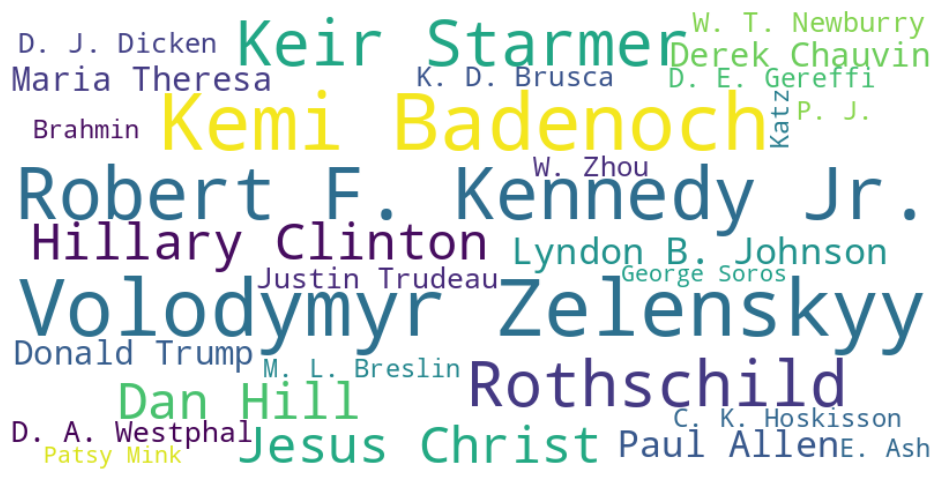

In [31]:
generate_keyword_cloud(ner_sets, labels)


In [32]:
ner_set_1 = df_m.loc[0,"organizations_diff"]
ner_set_2 = df_m.loc[1,"organizations_diff"]
ner_set_3 = df_m.loc[2,"organizations_diff"]

ner_sets = [ner_set_1, ner_set_2, ner_set_3]
labels = ["Llama3", "Mistral", "GPT-4o"]


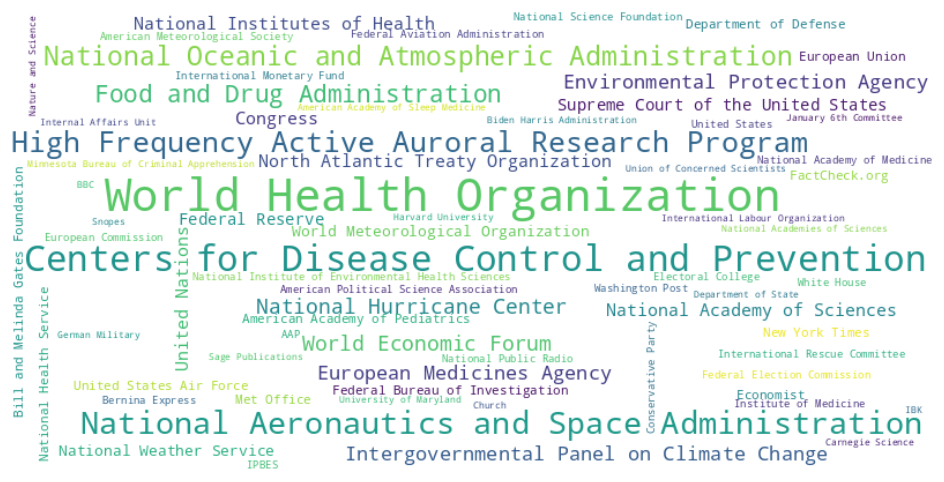

In [33]:
generate_keyword_cloud(ner_sets, labels)

## Compute setwise diffs

This should be more robust as not all NERs were successfully extracted from messages

In [34]:
def compute_set_per_model(ners):
    ner_list = []
    for elem in ners:
        flat = [item for item in elem if item is not None]
        ner_list.extend(flat)
        
    return ner_list 

In [35]:
df_m["persons_message_set"] = df_m["persons_message_normalized"].map(compute_set_per_model)
df_m["persons_response_set"] = df_m["persons_response_normalized"].map(compute_set_per_model)
df_m["organizations_message_set"] = df_m["organizations_message_normalized"].map(compute_set_per_model)
df_m["organizations_response_set"] = df_m["organizations_response_normalized"].map(compute_set_per_model)

In [36]:
df_m["persons_diff_set"] = df_m.apply(
    lambda row: [x for x in row["persons_response_set"] if x not in row["persons_message_set"]], axis=1) 
df_m["organizations_diff_set"] = df_m.apply(
    lambda row: [x for x in row["organizations_response_set"] if x not in row["organizations_message_set"]], axis=1) 

In [37]:
ner_set_1 = df_m.loc[0,"persons_diff_set"]
ner_set_2 = df_m.loc[1,"persons_diff_set"]
ner_set_3 = df_m.loc[2,"persons_diff_set"]

ner_sets = [ner_set_1, ner_set_2, ner_set_3]
labels = ["Llama3", "Mistral", "GPT-4o"]


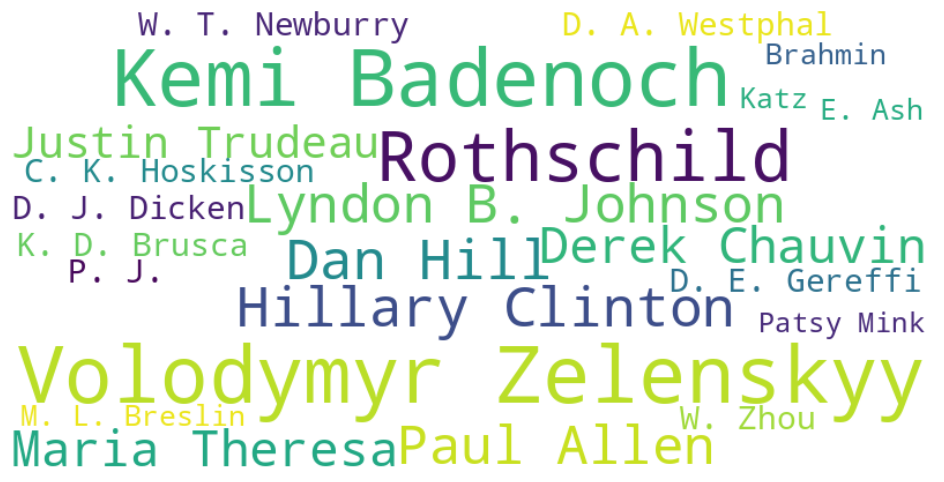

In [38]:
generate_keyword_cloud(ner_sets, labels)

### Manual correction of NERs from messages

Not all were extracted, thus manual post-processing

- Kemi Badenoch, Volodymyr Zelenskyy, Rothschild, Brahmin, Trudeau appear in messages
- Maria Theresa: Reference factually wrong
- Patsy Mink: Quote in part hallucinated 
- Dan Hill: Reference factually wrong
- Katz refers to Dr. Katz who was a virologist at Harvard, but the response was factually wrong
- D. A. Westphal, K. D. Brusca, W. T. Newburry, D. J. Dicken, E. Ash, C. K. Hoskisson, W. Zhou, M. L. Breslin, D. E. Gereffi, P. J.: belong to a hallucinated Reference
- Clinton: generated by model in the context of 2016 elections, thus context fits
- Lyndon B. Johnson: was vice president under JHK. Message refers to VP of JFK, thus context fits
- Paul Allen: not part of the message and context fits
- Derek Chauvin: not part of the message and context fits


In [39]:

ner_set_1 = df_m.loc[0,"organizations_diff_set"]
ner_set_2 = df_m.loc[1,"organizations_diff_set"]
ner_set_3 = df_m.loc[2,"organizations_diff_set"]

ner_sets = [ner_set_1, ner_set_2, ner_set_3]
labels = ["Llama3", "Mistral", "GPT-4o"]


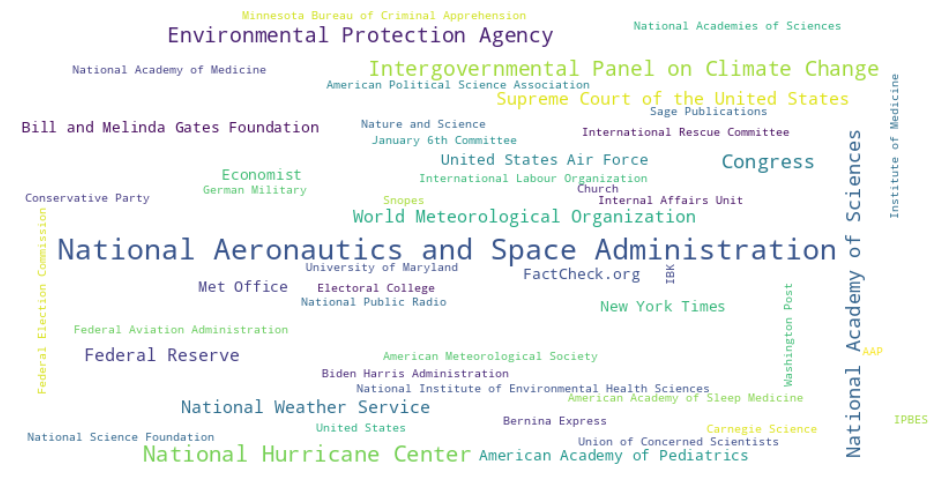

In [40]:
generate_keyword_cloud(ner_sets, labels)


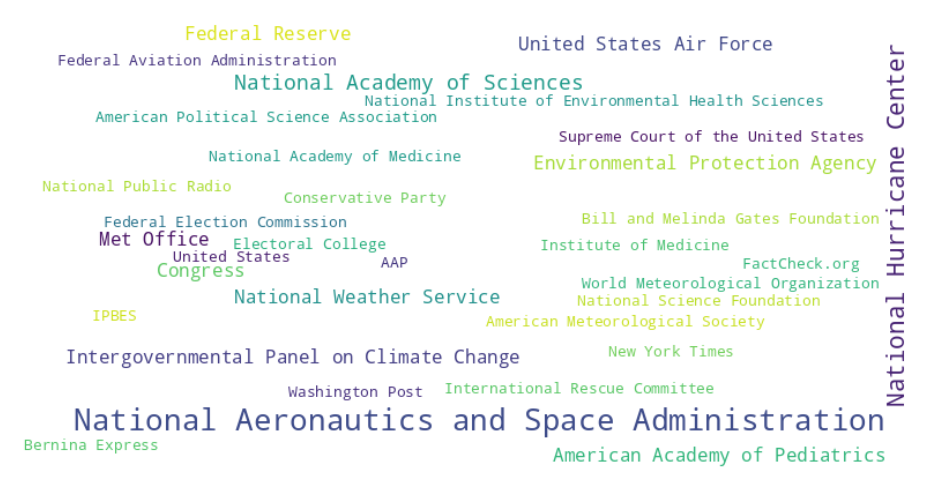

In [41]:
generate_keyword_cloud([ner_sets[0]], [labels[0]])


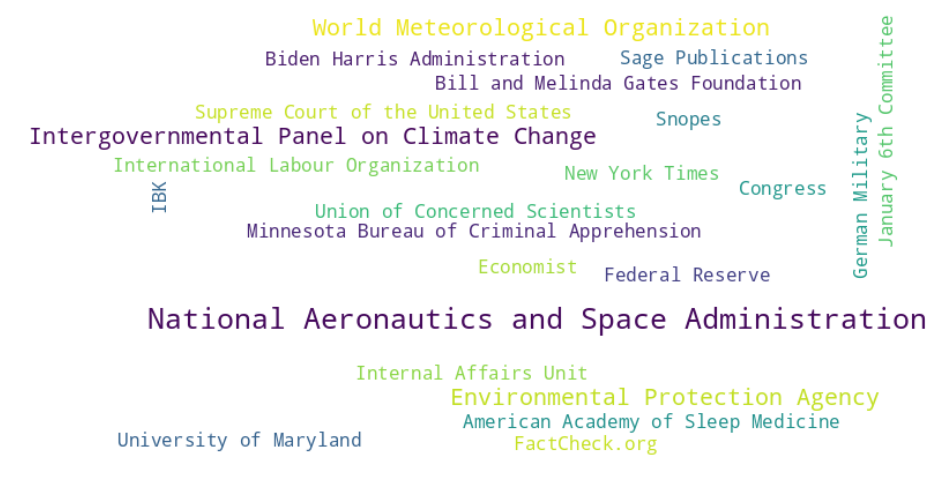

In [42]:
generate_keyword_cloud([ner_sets[1]], [labels[1]])


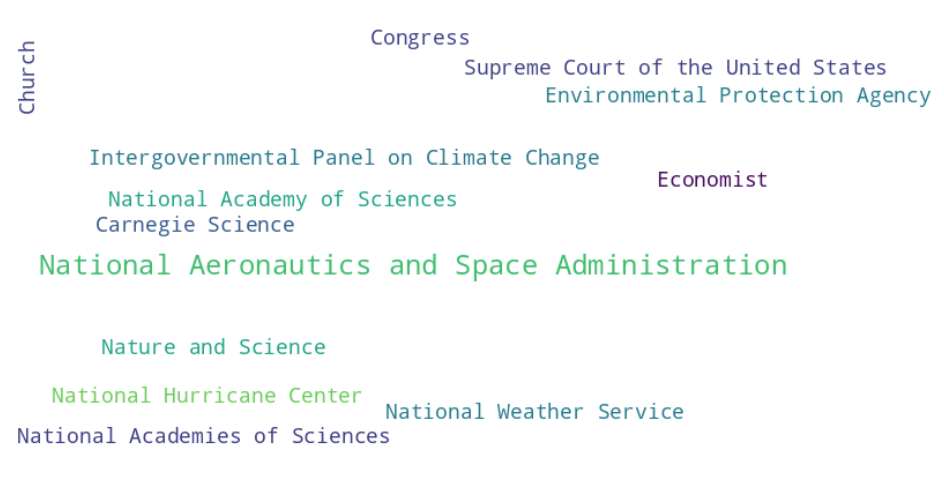

In [43]:
generate_keyword_cloud([ner_sets[2]], [labels[2]])
